In [ ]:
pip install celluloid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import math

import torch
import torch.nn as nn
from torch.autograd import Function
import torchsummary

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
from datetime import datetime
from celluloid import Camera
from IPython.display import HTML

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Parameter

In [ ]:
batch_size = 128
n_epochs = 100
z_dim = 100

In [ ]:
cuda = True if torch.cuda.is_available() else False
cuda

True

# Data

In [ ]:
path_data = '/content/drive/MyDrive/Colab Notebooks/gan/data'

dataloader = DataLoader(
    datasets.MNIST(path_data, 
                   train=True, 
                   download=True,
                   transform=transforms.Compose([transforms.ToTensor()])), 
    batch_size=batch_size,
    shuffle=True,
    drop_last=True)

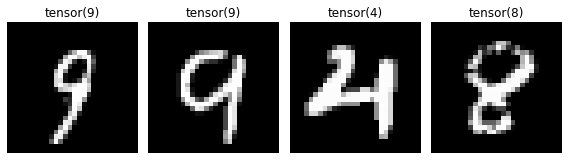

In [ ]:
images, labels = next(iter(dataloader))

fig = plt.figure(figsize=(8, 8))
for idx in range(4):
  image = images[idx]
  label = labels[idx]

  fig.add_subplot(1, 4, idx+1)
  plt.axis('off')
  plt.title(label)
  plt.imshow(image[0], cmap='gray')

fig.tight_layout()
plt.savefig(path_data+'/mnist_test.png', dpi=300)
plt.show()

In [ ]:
labels.shape

torch.Size([128])

In [ ]:
torch.arange(0, 10).shape

torch.Size([10])

# Model

In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim=100, img_shape=(28,28), n_classes=10):
    super(Generator, self).__init__()

    self.z_dim = z_dim
    self.img_shape=img_shape
    self.n_classes = n_classes

    self.model = nn.Sequential(
        nn.Linear(self.z_dim + self.n_classes, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 784),
        nn.Sigmoid()
    )

  def forward(self, z, labels):
    labels = nn.functional.one_hot(labels, num_classes=self.n_classes)
    z = torch.cat((z, labels), 1)
    img = self.model(z)
    img = img.view(img.size(0), *self.img_shape)
    return img

In [ ]:
class Maxout(nn.Module):
  def __init__(self, k=3):
    super(Maxout, self).__init__()

    self.k = k

    self.weight = torch.randn(self.k, requires_grad=True).unsqueeze(1).cuda()
    self.bias = torch.randn(self.k, requires_grad=True).unsqueeze(0).cuda()

  def forward(self, input):
    x = input.flatten().unsqueeze(1)
    x = nn.functional.linear(x, self.weight, self.bias)
    x = nn.functional.max_pool1d(x, self.k)
    x = x.reshape(*input.shape)
    return x


class Discriminator(nn.Module):
  def __init__(self, img_shape=28*28, n_classes=10):
    super(Discriminator, self).__init__()
    self.n_classes = n_classes

    self.model = nn.Sequential(
        nn.Linear(img_shape + n_classes, 512),
        Maxout(),
        nn.Linear(512, 256),
        Maxout(),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

  def forward(self, img, labels):
    labels = nn.functional.one_hot(labels, num_classes=self.n_classes)
    img = torch.cat((img, labels), 1)
    output = self.model(img)
    return output

# Train

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
loss = nn.BCELoss().cuda()

In [ ]:
generator.cuda()
discriminator.cuda()
loss.cuda()

BCELoss()

In [ ]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.001)

In [ ]:
sample_img = torch.zeros(10, z_dim)
sample_img += (0.1**0.5)*torch.randn(10, z_dim)
sample_img = sample_img.cuda()
sample_label = torch.arange(0, 10)
sample_label = sample_label.cuda()

ones = ((torch.rand(batch_size, 1) * 0.1) + 0.9).cuda()
ones.requires_grad = False
zeros = torch.zeros(batch_size, 1).cuda()
zeros.requires_grad = False

In [ ]:
history = {'D': [], 'G': []}
list_test = []

In [ ]:
# k = 1

for epoch in range(n_epochs):
  time_before = datetime.now()

  for i, (images, labels) in enumerate(dataloader):
    images = images.reshape(batch_size, -1).cuda()
    labels = labels.cuda()

    # gaussian noise vector
    z = torch.zeros(batch_size, z_dim)
    z += (0.1**0.5)*torch.randn(batch_size, z_dim)
    z = z.cuda()


    '''
    Discriminator
    '''
    optimizer_D.zero_grad()

    # generated image
    image_fake = generator(z, labels)
    image_fake = image_fake.reshape(batch_size, -1)


    # discriminator classfy images
    result_real = discriminator(images, labels)
    result_fake = discriminator(image_fake, labels)

    # loss
    loss_real = loss(result_real, ones)
    loss_fake = loss(result_fake, zeros)
    loss_D = (loss_real + loss_fake) / 2

    # update D
    loss_D.backward()
    optimizer_D.step()


    '''
    Generator
    '''
    optimizer_G.zero_grad()
    
    # generator image
    image_fake = generator(z, labels)
    image_fake = image_fake.reshape(batch_size, -1)
    
    # loss
    result_fake = discriminator(image_fake, labels)
    loss_G = loss(result_fake, ones)
    loss_G = (-1 * torch.log(result_fake)).mean()

    # update G
    loss_G.backward()
    optimizer_G.step()
  

  '''
  History
  '''
  time_after = datetime.now() - time_before
  print('%2dM %2dS / Epoch %2d loss_D: %.8f, loss_G: %.8f' %
        (*divmod(time_after.seconds, 60), (epoch+1), loss_D.item(), loss_G.item()))

  history['D'].append(loss_D.item())
  history['G'].append(loss_G.item())

  with torch.no_grad():
    test = generator(sample_img, sample_label).cpu().detach().numpy()
    list_test.append(test)

 0M 11S / Epoch  1 loss_D: 0.13589975, loss_G: 5.09475327
 0M 16S / Epoch  2 loss_D: 0.12242558, loss_G: 4.71182394
 0M 10S / Epoch  3 loss_D: 0.11946683, loss_G: 4.91914368
 0M 10S / Epoch  4 loss_D: 0.12556607, loss_G: 5.59648132
 0M 11S / Epoch  5 loss_D: 0.16540194, loss_G: 3.81179142
 0M 10S / Epoch  6 loss_D: 0.19761792, loss_G: 5.15830183
 0M 10S / Epoch  7 loss_D: 0.19264929, loss_G: 5.09556818
 0M 10S / Epoch  8 loss_D: 0.19169641, loss_G: 4.15840721
 0M 11S / Epoch  9 loss_D: 0.18378109, loss_G: 5.22497463
 0M 10S / Epoch 10 loss_D: 0.20867318, loss_G: 3.38141251
 0M 10S / Epoch 11 loss_D: 0.23855616, loss_G: 3.93259811
 0M 10S / Epoch 12 loss_D: 0.25525075, loss_G: 3.94856119
 0M 10S / Epoch 13 loss_D: 0.27048522, loss_G: 2.79174042
 0M 10S / Epoch 14 loss_D: 0.27349448, loss_G: 4.30684614
 0M 10S / Epoch 15 loss_D: 0.22225462, loss_G: 3.82219672
 0M 10S / Epoch 16 loss_D: 0.50256932, loss_G: 1.69613504
 0M 10S / Epoch 17 loss_D: 0.35841793, loss_G: 4.29958248
 0M 10S / Epoc

# Graph

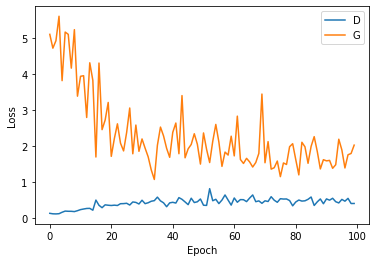

In [ ]:
epoch = [i for i in range(n_epochs)]
plt.plot(epoch, history['D'])
plt.plot(epoch, history['G'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['D', 'G'])

plt.savefig(path_data+'/graph.png', dpi=300)
plt.show()

# Result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


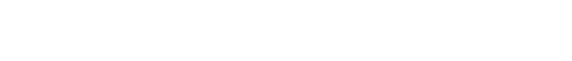

In [ ]:
fig = plt.figure(figsize=(10, 5))
camera = Camera(fig)

for epoch in range(n_epochs):
  for idx, image in enumerate(list_test[epoch]):
    fig.add_subplot(1, 10, idx+1)
    plt.axis('off')
    plt.imshow(list_test[epoch][idx], cmap='gray')
    
  # fig.tight_layout()
  camera.snap()
animation = camera.animate(interval=100)
animation.save(path_data+'/history_result.mp4', dpi=300)

HTML(animation.to_html5_video())

In [ ]:
img = torch.zeros(10, z_dim)
img += (0.1**0.5)*torch.randn(10, z_dim)
img = img.cuda()
label = torch.arange(0, 10)
label = sample_label.cuda()

image_fake = generator(img, label)
image_fake = image_fake.cpu().detach().numpy()

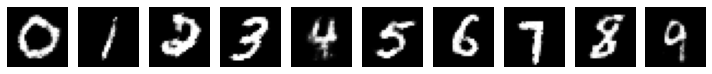

In [ ]:
fig = plt.figure(figsize=(10, 5))
for idx, image in enumerate(image_fake[:100]):
  fig.add_subplot(1, 10, idx+1)
  plt.axis('off')
  plt.imshow(image, cmap='gray')

fig.tight_layout()
plt.savefig(path_data+'/random_result.png', dpi=300)
plt.show()